### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.


In [61]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [62]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [63]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [64]:
# 1. Import data #

time0 = time.time()
df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
df.dropna(axis=0, subset=['bm', 'lbm', 'llme', 'lop', 'op', 'linv', 'mom122', 'beta_bw', 'ind'], inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.sample(500000)
display(df.shape, df.head(), df.count())

(500000, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
24754,10516,583,176.359758,73.441237,2006,-8.9914,2.0,-0.558674,0.090203,0.166468,-0.039792,1.226700,51.124143,-4.463255,1.893507,1.642687,1.132881,4.0361,2.026777,2.301513,2.243252,0.029163,10.138971,-0.558664,0.075694,0.145437,0.127216,9.675290,-4.413513,2.957100,0.029163,-4.275726,4.9198,0.029163,-4.106334,4.6170,0.157895,-3.973023,2.957100,0.285831,26.289052,1.110956,0.829009,0.914059,1.566515,2.083331
871216,72486,475,-57.265976,-45.032562,1997,-5.7954,35.0,0.382251,-0.011705,0.512255,0.140350,-22.380465,39.656999,1.008567,3.865288,3.337962,1.342912,9.1820,5.153912,4.445470,4.005972,0.540541,5.189703,-0.240851,0.237031,0.760029,0.110502,5.092572,1.025213,21.135115,0.800000,1.035256,11.2486,1.052632,0.844400,2.6116,2.898551,0.297797,21.135115,2.409639,-30.855380,2.241253,1.849664,1.147520,3.002618,3.396079
1263312,91837,654,NaN,NaN,2012,7.2868,2.0,1.170077,0.020398,0.264525,-0.048470,-1.319300,13.120335,1.999913,3.178143,2.769494,0.801295,6.1962,3.158612,6.397387,5.302053,0.332226,4.781621,-0.383464,-0.026280,0.244258,0.054629,4.792733,2.034166,3.828500,0.646204,2.096141,7.2202,0.142450,2.092315,8.6379,0.655738,1.342052,3.828500,0.867679,-41.001808,2.674886,2.352131,0.827959,3.727579,3.493450
1003915,79007,493,78.803834,83.898431,1999,7.0980,43.0,-0.492379,0.124321,0.749175,-0.081543,20.630000,5.298861,2.637574,3.725205,3.287315,0.841777,13.6662,3.778359,3.466458,3.594777,0.413223,5.299365,-0.146282,-0.035868,0.556935,-0.027483,5.005556,2.645495,8.315300,1.485149,2.646992,3.7310,0.662252,2.650675,9.9850,2.857143,2.464920,8.315300,2.000000,64.446651,2.825106,1.892719,0.850100,3.045258,3.054876
301830,27334,268,283.349209,133.410201,1980,3.8788,23.0,-0.278489,0.266020,0.489221,0.325485,10.036000,49.766223,3.222145,3.138099,2.960963,1.148705,11.5702,3.786842,2.863860,2.601979,NaN,5.105031,0.230423,0.272473,0.518809,0.080581,4.527471,3.274573,7.174400,NaN,3.303809,8.2743,NaN,3.126726,3.1555,NaN,3.419906,7.174400,NaN,43.534268,2.115387,1.994306,0.961529,2.137674,1.990289


PERMNO          500000
prd             500000
mom482          425629
mom242          490714
year            500000
RET             500000
ind             500000
bm              500000
op              500000
gp              500000
inv             499547
mom11           500000
mom122          500000
amhd            411580
ivol_capm       499975
ivol_ff5        499975
beta_bw         500000
MAX             500000
vol1m           499917
vol6m           499555
vol12m          498831
BAspr           291382
size            500000
lbm             500000
lop             500000
lgp             500000
linv            500000
llme            500000
l1amhd          411291
l1MAX           499983
l1BAspr         290558
l3amhd          410746
l3MAX           499882
l3BAspr         289172
l6amhd          409922
l6MAX           499802
l6BAspr         286517
l12amhd         407556
l12MAX          499983
l12BAspr        281649
l12mom122       496630
l12ivol_capm    499536
l12ivol_ff5     499536
l12beta_bw 

<AxesSubplot:>

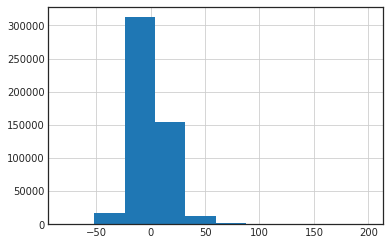

In [65]:
# 2. pEDA #

df.RET.hist()

In [66]:
# explore feature distibution, adjust if seems unreasonable

In [67]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
24754,10516,583,176.359758,73.441237,2006,-8.9914,2.0,-0.558674,0.090203,0.166468,-0.039792,1.226700,51.124143,-4.463255,1.893507,1.642687,1.132881,4.0361,2.026777,2.301513,2.243252,0.029163,10.138971,-0.558664,0.075694,0.145437,0.127216,9.675290,-4.413513,2.957100,0.029163,-4.275726,4.9198,0.029163,-4.106334,4.6170,0.157895,-3.973023,2.957100,0.285831,26.289052,1.110956,0.829009,0.914059,1.566515,2.083331,0,0
871216,72486,475,-57.265976,-45.032562,1997,-5.7954,35.0,0.382251,-0.011705,0.512255,0.140350,-22.380465,39.656999,1.008567,3.865288,3.337962,1.342912,9.1820,5.153912,4.445470,4.005972,0.540541,5.189703,-0.240851,0.237031,0.760029,0.110502,5.092572,1.025213,21.135115,0.800000,1.035256,11.2486,1.052632,0.844400,2.6116,2.898551,0.297797,21.135115,2.409639,-30.855380,2.241253,1.849664,1.147520,3.002618,3.396079,0,0
1263312,91837,654,NaN,NaN,2012,7.2868,2.0,1.170077,0.020398,0.264525,-0.048470,-1.319300,13.120335,1.999913,3.178143,2.769494,0.801295,6.1962,3.158612,6.397387,5.302053,0.332226,4.781621,-0.383464,-0.026280,0.244258,0.054629,4.792733,2.034166,3.828500,0.646204,2.096141,7.2202,0.142450,2.092315,8.6379,0.655738,1.342052,3.828500,0.867679,-41.001808,2.674886,2.352131,0.827959,3.727579,3.493450,0,0
1003915,79007,493,78.803834,83.898431,1999,7.0980,43.0,-0.492379,0.124321,0.749175,-0.081543,20.630000,5.298861,2.637574,3.725205,3.287315,0.841777,13.6662,3.778359,3.466458,3.594777,0.413223,5.299365,-0.146282,-0.035868,0.556935,-0.027483,5.005556,2.645495,8.315300,1.485149,2.646992,3.7310,0.662252,2.650675,9.9850,2.857143,2.464920,8.315300,2.000000,64.446651,2.825106,1.892719,0.850100,3.045258,3.054876,0,0
301830,27334,268,283.349209,133.410201,1980,3.8788,23.0,-0.278489,0.266020,0.489221,0.325485,10.036000,49.766223,3.222145,3.138099,2.960963,1.148705,11.5702,3.786842,2.863860,2.601979,NaN,5.105031,0.230423,0.272473,0.518809,0.080581,4.527471,3.274573,7.174400,NaN,3.303809,8.2743,NaN,3.126726,3.1555,NaN,3.419906,7.174400,NaN,43.534268,2.115387,1.994306,0.961529,2.137674,1.990289,0,1


In [68]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.year<2016]
test = df[df.year>=2016]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

(478874, 45)

(21126, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,176.359758,73.441237,-8.9914,2.0,-0.558674,0.090203,0.166468,-0.039792,1.226700,51.124143,-4.463255,1.893507,1.642687,1.132881,4.0361,2.026777,2.301513,2.243252,0.029163,10.138971,-0.558664,0.075694,0.145437,0.127216,9.675290,-4.413513,2.957100,0.029163,-4.275726,4.9198,0.029163,-4.106334,4.6170,0.157895,-3.973023,2.957100,0.285831,26.289052,1.110956,0.829009,0.914059,1.566515,2.083331,0,0
1,-57.265976,-45.032562,-5.7954,35.0,0.382251,-0.011705,0.512255,0.140350,-22.380465,39.656999,1.008567,3.865288,3.337962,1.342912,9.1820,5.153912,4.445470,4.005972,0.540541,5.189703,-0.240851,0.237031,0.760029,0.110502,5.092572,1.025213,21.135115,0.800000,1.035256,11.2486,1.052632,0.844400,2.6116,2.898551,0.297797,21.135115,2.409639,-30.855380,2.241253,1.849664,1.147520,3.002618,3.396079,0,0
2,NaN,NaN,7.2868,2.0,1.170077,0.020398,0.264525,-0.048470,-1.319300,13.120335,1.999913,3.178143,2.769494,0.801295,6.1962,3.158612,6.397387,5.302053,0.332226,4.781621,-0.383464,-0.026280,0.244258,0.054629,4.792733,2.034166,3.828500,0.646204,2.096141,7.2202,0.142450,2.092315,8.6379,0.655738,1.342052,3.828500,0.867679,-41.001808,2.674886,2.352131,0.827959,3.727579,3.493450,0,0


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,95.438135,10.733997,-3.3003,7.0,-0.455080,0.162481,0.377474,0.031809,-2.8219,13.712694,0.701320,2.263010,2.031816,1.007247,7.3186,2.764227,2.411597,2.129968,0.292826,5.846798,-0.702919,0.184985,0.407017,-0.014497,5.723574,0.809948,7.0184,0.714967,1.009413,1.8569,0.221141,1.280392,2.9982,0.173611,1.381726,7.0184,0.323276,-8.222723,1.698998,1.377168,1.372075,2.662855,2.387393,0,0
1,NaN,-39.913708,-3.4600,30.0,0.190221,0.170266,0.203607,0.223073,-7.4902,28.201480,-3.570285,1.328922,1.255872,0.973313,2.1145,1.466879,2.006033,2.911217,0.039904,8.947457,-0.771174,0.137733,0.172681,0.749959,8.649971,-3.421372,4.2825,0.038565,-3.284548,4.4537,0.038820,-3.169157,4.5357,0.034329,-3.272097,4.2825,0.047687,-49.765657,4.033896,3.226864,1.252497,3.314202,3.050424,0,0
2,36.928655,26.462302,-4.0485,16.0,-0.578997,0.108499,0.209926,0.105991,6.7020,23.239140,-0.439693,1.209944,0.906851,1.169143,4.4022,1.443144,1.597765,1.712648,0.053865,6.543669,-0.521442,0.112038,0.227148,0.015573,6.250009,-0.425686,3.6408,0.029163,-0.317304,9.0719,0.155763,-0.224665,4.4999,0.036062,-0.206434,3.6408,0.035398,-3.945672,1.689567,1.266355,1.049934,1.992002,2.418204,0,0


In [69]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          478874
mom242          478874
RET             478874
ind             478874
bm              478874
op              478874
gp              478874
inv             478874
mom11           478874
mom122          478874
amhd            478874
ivol_capm       478874
ivol_ff5        478874
beta_bw         478874
MAX             478874
vol1m           478874
vol6m           478874
vol12m          478874
BAspr           478874
size            478874
lbm             478874
lop             478874
lgp             478874
linv            478874
llme            478874
l1amhd          478874
l1MAX           478874
l1BAspr         478874
l3amhd          478874
l3MAX           478874
l3BAspr         478874
l6amhd          478874
l6MAX           478874
l6BAspr         478874
l12amhd         478874
l12MAX          478874
l12BAspr        478874
l12mom122       478874
l12ivol_capm    478874
l12ivol_ff5     478874
l12beta_bw      478874
l12vol6m        478874
l12vol12m       478874
amhd_miss  

In [70]:
# [optional] Target Encoding


In [71]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [72]:
# 5. Feature engineering #

time1 = time.time()

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),
    ('num', StandardScaler(), col_num)])

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (478874, 44)
time to do feature proprocessing:  1.1434450149536133
Number of features after transformation:  (478874, 92)


In [73]:
X_train

,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.646387,0.942962,-0.152753,-0.056214,-1.106608,-0.699435,0.069402,1.070614,-2.340343,-0.509160,-0.503052,0.683019,-0.559251,-0.542718,-0.532654,-0.606236,-0.796058,2.407773,-0.133827,-0.210169,-1.204256,-0.017280,2.261759,-2.329647,-0.774032,-0.800528,-2.293970,-0.384751,-0.805106,-2.253832,-0.445162,-0.765331,-2.249299,-0.774032,-0.733233,0.466676,-0.946661,-1.015050,0.064887,-0.954148,-0.702101,-0.474657,-0.878545
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.959323,-0.948070,0.868897,-0.989710,0.462205,0.096288,-1.926357,0.797856,-0.358460,0.553213,0.526425,1.263332,0.452743,1.086731,0.669647,0.416037,-0.608302,0.199965,0.208400,1.263479,1.579339,-0.088610,0.181381,-0.355467,2.816526,-0.515894,-0.358443,0.873341,-0.425128,-0.439108,-0.845936,0.262360,-0.663997,2.816526,0.074373,-0.892594,-0.320097,-0.377383,0.706144,-0.128710,0.081178,-0.474657,-0.878545
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.244778,-0.185276,1.724312,-0.695638,-0.661733,-0.737769,-0.145837,0.166654,0.000604,0.182987,0.181215,-0.233147,-0.134445,0.047044,1.764255,1.167687,-0.684786,0.017925,0.054831,-1.141606,-0.756679,-0.327057,0.045265,0.010769,-0.601911,-0.572683,0.028184,0.072542,-0.763047,0.018323,0.358405,-0.578650,-0.276376,-0.601911,-0.511977,-1.133943,-0.079718,-0.063460,-0.171609,0.287981,0.139277,-0.474657,-0.878545
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.558311,1.109876,-0.080771,0.256319,1.537091,-0.883860,1.709766,-0.019388,0.231564,0.477738,0.495669,-0.121293,1.334607,0.369974,0.120631,0.177568,-0.655047,0.248884,0.310233,-1.229180,0.659492,-0.677485,0.141879,0.232673,0.284330,-0.262900,0.228936,-0.621070,-0.570063,0.222993,0.627620,0.246833,0.140426,0.284330,-0.081397,1.374314,0.003554,-0.350484,-0.110791,-0.104201,-0.122408,-0.474657,-0.878545
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.839678,1.900163,0.151470,1.554307,0.357698,0.914065,0.814144,1.038314,0.443294,0.161412,0.297487,0.726741,0.922407,0.374395,-0.217297,-0.398196,-0.296824,0.162194,0.71587

In [79]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=6, eta=0.05, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 10.362791243793783
R2 of a constant model 0.0
XGB train: 10.194930791764909 0.07814769232439722 10.420358419418335


In [75]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[300, 500], 'max_depth':[2,4,6], 'eta':[0.02, 0.04, 0.06],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='neg_mean_absolute_error')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=6, n_estimators=300, subsample=0.6; tota

In [76]:
time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 20.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
                      
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        score_test = mean_absolute_error(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'

optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

[I 2022-08-24 22:55:32,784] A new study created in memory with name: no-name-11776cbf-0370-4b7b-924b-014672c30127
[I 2022-08-24 22:56:01,909] Trial 0 finished with value: 10.656709631947574 and parameters: {'n_estimators': 434, 'max_depth': 8, 'learning_rate': 0.11585359649002928, 'colsample_bytree': 0.9365182290058566, 'subsample': 0.925172831143214, 'alpha': 0.6448957939999528, 'lambda': 0.38716227485054366, 'gamma': 1.3112887819998422, 'min_child_weight': 1.1547632708971387}. Best is trial 0 with value: 10.656709631947574.
[I 2022-08-24 22:56:08,629] Trial 1 finished with value: 10.424179001899951 and parameters: {'n_estimators': 233, 'max_depth': 3, 'learning_rate': 0.013678529147301957, 'colsample_bytree': 0.5757720334984112, 'subsample': 0.5546188374471677, 'alpha': 18.02875663451166, 'lambda': 0.1590212506254541, 'gamma': 4.065243787297455e-08, 'min_child_weight': 9.05694318397275}. Best is trial 1 with value: 10.424179001899951.
[I 2022-08-24 22:56:16,499] Trial 2 finished with

Total time for hypermarameter optimization  388.68152022361755
        n_estimators : 176
           max_depth : 7
       learning_rate : 0.02524017396862495
    colsample_bytree : 0.4240592889838349
           subsample : 0.752393065433362
               alpha : 0.34031034473211
              lambda : 63.45292590397274
               gamma : 0.35620860767445406
    min_child_weight : 0.7812197839031524
best objective value : 10.4050568012254


NameError: name 'XGBClassifier' is not defined

In [81]:
# Evaluate performance of XGB models:

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

XGB test: 8.807566112297426 -0.001447285187983871
XGB GS test: 8.787164657266725 1.2358967773629104e-06
Optuna XGB test: 8.779803817284662 0.001301060059168302


In [ ]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))